# Lens modeling with lenstronomy
Author: Sulyman Hossain (Robin), Mir Sazzat Hossain, Anowar J. Shajib \
Acknowledgement: Rafe Adnan, MH Tanver

In [1]:
import corner

# import of standard python libraries
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
import yaml
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Workflow.fitting_sequence import FittingSequence
import lenstronomy.Util.param_util as param_util

# import lenstronomy.Util.util as util
from light_profile import LightProfileAnalysis

%matplotlib inline

In [2]:
# Moving the backend file from output dataset to working directory
"""src_path = r"/kaggle/input/output-files-2nd/mcmc_backend.h5"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)"""

'src_path = r"/kaggle/input/output-files-2nd/mcmc_backend.h5"\ndst_path = r"/kaggle/working/"\nshutil.copy(src_path, dst_path)'

### Extracting the observed image data from a .h5 file

In [3]:
with h5py.File("DESIJ1205+4110_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
# kwargs_data

### Extracting the information about Point Spread Function(PSF) from a .h5 file

In [4]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"
# kwargs_psf

# Visualizing the image

/tmp/ipykernel_9719/3760669365.py:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


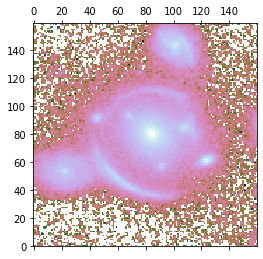

In [5]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
# plt.grid(which='both', color='black')
# plt.minorticks_on()
# plt.grid(which='minor', color='black')
plt.show()

# Masking

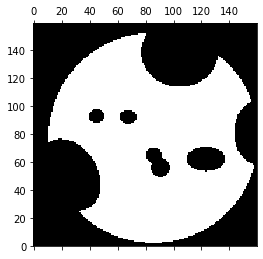

/tmp/ipykernel_9719/325429954.py:136: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
/tmp/ipykernel_9719/325429954.py:136: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


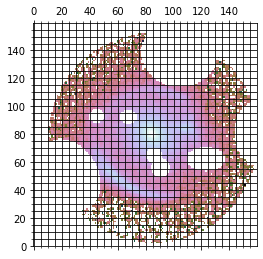

In [6]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 6  # arcseconds
lens_center_ra = 0.4
lens_center_dec = -0.8

mask_outer = mask_util.mask_center_2d(
    lens_center_ra - 0.8,
    lens_center_dec + 0.5,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

mask_ext_1_oclock = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.3,
    lens_center_dec + 5.4,
    2.2,
    2,
    0,
)

mask_ext_2_oclock = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.8,
    lens_center_dec + 1.1,
    0.1,
    0.1,
    0,
)

mask_ext_3_oclock = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 7,
    lens_center_dec + 0.8,
    1.6,
    1.9,
    0,
)

mask_ext_4_oclock = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.8,
    lens_center_dec - 0.7,
    1.1,
    0.7,
    0,
)

mask_ext_5_oclock = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 1.2,
    lens_center_dec - 1.2,
    0.55,
    0.55,
    0,
)

mask_ext_6_oclock = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.83,
    lens_center_dec - 0.5,
    0.45,
    0.45,
    0,
)

mask_ext_7_oclock = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 4,
    lens_center_dec - 1.6,
    2.2,
    1.6,
    1,
)


mask_ext_8_oclock = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 2.45,
    lens_center_dec + 1.75,
    0.45,
    0.4,
    0,
)
mask_ext_9_oclock = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.65,
    lens_center_dec + 1.7,
    0.5,
    0.4,
    0,
)


mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1_oclock)
    # * (1 - mask_ext_2_oclock)
    * (1 - mask_ext_3_oclock)
    * (1 - mask_ext_4_oclock)
    * (1 - mask_ext_5_oclock)
    * (1 - mask_ext_6_oclock)
    * (1 - mask_ext_7_oclock)
    * (1 - mask_ext_8_oclock)
    * (1 - mask_ext_9_oclock)
)

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

plt.matshow(mask, origin="lower", cmap="cubehelix")
plt.show()

# Masking Image Data
masked_image_data = np.multiply(image_data, mask)
plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{q x^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [7]:
lens_model_list = [
    "EPL",
    "SHEAR",
    #    'SIE'
    "FLEXION",
]
source_model_list = [
    "SERSIC_ELLIPSE",
    "SHAPELETS",
    #    "SHAPELETS",
]
lens_light_model_list = [
    "SERSIC_ELLIPSE",
    "SERSIC_ELLIPSE",
    #    "SERSIC_ELLIPSE",
]

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

### Mass model of the lens galaxy

In [8]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []
# EPL Profile

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 2.80,
        "gamma": 2.0,
        "e1": 0.064,
        "e2": 0.226,
        "center_x": -0.24,
        "center_y": -0.1092,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.5,
        "gamma": 0.5,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 2.0,
        "gamma": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {"theta_E": 10, "gamma": 3, "e1": 0.5, "e2": 0.5, "center_x": 10, "center_y": 10}
)

# SHEAR Profile

fixed_lens.append({"ra_0": 0.0, "dec_0": 0.0})
kwargs_lens_init.append(
    {
        "gamma1": -0.020,
        "gamma2": 0.1178,
        "ra_0": 0.0,
        "dec_0": 0.0,
    }
)
kwargs_lens_sigma.append({"gamma1": 0.05, "gamma2": 0.05, "ra_0": 0.2, "dec_0": 0.2})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3, "ra_0": -10, "dec_0": -10})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3, "ra_0": 10, "dec_0": 10})


"""# Satellite Galaxy Mass Profile: SIE

satellite_center_x = -2.7
satellite_center_y = +1.
satellite_centroid_bound = 0.8

fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 0.6211496,
        "e1": 0.0244,
        "e2": -0.035,
        "center_x": satellite_center_x,
        "center_y": satellite_center_y,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": satellite_centroid_bound / 4,
        "center_y": satellite_centroid_bound / 4,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": satellite_center_x - satellite_centroid_bound,
        "center_y": satellite_center_y - satellite_centroid_bound,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 2.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": satellite_center_x + satellite_centroid_bound,
        "center_y": satellite_center_y + satellite_centroid_bound,
    }
)"""

# FLEXION
fixed_lens.append({"ra_0": 0.0, "dec_0": 0.0})
kwargs_lens_init.append(
    {"g1": -0.022, "g2": 0.011, "g3": -0.04, "g4": -0.032, "ra_0": 0.0, "dec_0": 0.0}
)
kwargs_lens_sigma.append(
    {"g1": 0.01, "g2": 0.01, "g3": 0.01, "g4": 0.01, "ra_0": 0.0, "dec_0": 0.0}
)
kwargs_lower_lens.append(
    {"g1": -0.1, "g2": -0.1, "g3": -0.1, "g4": -0.1, "ra_0": 0.0, "dec_0": 0.0}
)
kwargs_upper_lens.append(
    {"g1": 0.1, "g2": 0.1, "g3": 0.1, "g4": 0.1, "ra_0": 0.0, "dec_0": 0.0}
)


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

### Light model of the lens galaxy

In [9]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# 1st SERSIC_ELLIPSE Profile

fixed_lens_light.append({"n_sersic": 1.0})
kwargs_lens_light_init.append(
    {
        "amp": 1,
        "R_sersic": 2.352,
        "n_sersic": 1.0,
        "e1": 0.25,
        "e2": 0.255,
        "center_x": -0.32,
        "center_y": -0.0633,
    }
)
kwargs_lens_light_sigma.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 0.5,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "R_sersic": 5.0,
        "n_sersic": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# 2nd SERSIC_ELLIPSE Profile


fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "amp": 1,
        "R_sersic": 0.7858,
        "n_sersic": 4.0,
        "e1": 0.0,
        "e2": 0.127,
        "center_x": -0.327,
        "center_y": -0.06,
    }
)
kwargs_lens_light_sigma.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 0.5,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "R_sersic": 5.0,
        "n_sersic": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


"""# 3rd Sersic Ellipse for Satellite Galaxy

fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 1.032,
        "n_sersic": 2,
        "e1": 0.02444,
        "e2": -0.035,
        "center_x": satellite_center_x,
        "center_y": satellite_center_y,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": satellite_centroid_bound / 4,
        "center_y": satellite_centroid_bound / 4,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": satellite_center_x - satellite_centroid_bound,
        "center_y": satellite_center_y - satellite_centroid_bound,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 5,
        "n_sersic": 5.0,
        "center_x": satellite_center_x + satellite_centroid_bound,
        "center_y": satellite_center_y + satellite_centroid_bound,
        "amp": 100,
    }
)
joint_lens_with_lens_light = [
    [2, 2, ["center_x", "center_y", "e1", "e2"]],
    #     [0, 0, ["center_x", "center_y", "e1", "e2"]]
]"""
joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

### Light model of the source galaxy

In [10]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# SERSIC_ELLIPSE profile

fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "amp": 1,
        "R_sersic": 0.22817,
        "n_sersic": 1.0,
        "e1": 0.377,
        "e2": -0.192,
        "center_x": 0.4100,
        "center_y": -0.4780,
    }
)
kwargs_source_sigma.append(
    {
        "R_sersic": 0.2,
        "n_sersic": 0.5,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 5.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# SHAPELETS profile

fixed_source.append({"n_max": 10})
kwargs_source_init.append(
    {
        "amp": 1,
        "n_max": 10,
        "beta": 0.02187,
        "center_x": 0.410,
        "center_y": -0.478,
    }
)
kwargs_source_sigma.append({"beta": 0.05, "center_x": 0.2, "center_y": 0.2})
kwargs_lower_source.append({"beta": 0.001, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.2, "center_x": 10, "center_y": 10})

joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]


# 2nd Shapelets

"""fixed_source.append({"n_max": 10})
kwargs_source_init.append(
    {
        "amp": 1,
        "n_max": 8,
        "beta": 0.02187,
        "center_x": 0.,
        "center_y": 0.,
    }
)
kwargs_source_sigma.append({"beta": 0.1, "center_x": 0.2, "center_y": 0.2})
kwargs_lower_source.append({"beta": 0.001, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.15, "center_x": 10, "center_y": 10})"""


source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

In [11]:
# Combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    #    "joint_lens_with_light": joint_lens_with_lens_light,
    "joint_source_with_source": joint_source_with_source,
}

#### Numerical settings

In [12]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 3, "supersampling_convolution": False}

#### Combining all the information to be sent to lenstronomy

In [13]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## Here the model fiting is done

In [14]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["update_settings", {"lens_add_fixed": [[0, ["gamma"]]]}],
    ["PSO", {"sigma_scale": 1.0, "n_particles": 10, "n_iterations": 10}],
    ["update_settings", {"lens_remove_fixed": [[0, ["gamma"]]]}],
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
Max iteration reached! Stopping.
-3.7567492618716574 reduced X^2 of best position
-25093.206694671735 log likelihood
13359 effective number of data points
[{'theta_E': 2.793425691356146, 'gamma': 2.0, 'e1': 0.06654266268517545, 'e2': 0.22644390407278564, 'center_x': -0.24000319612315366, 'center_y': -0.11027447706855467}, {'gamma1': -0.018462875705713998, 'gamma2': 0.13158668460003367, 'ra_0': 0.0, 'dec_0': 0.0}, {'g1': -0.021607352967654835, 'g2': 0.011807792103270931, 'g3': -0.0377785906372968, 'g4': -0.031240127796131584, 'ra_0': 0.0, 'dec_0': 0.0}] lens result
[{'amp': 1, 'R_sersic': 0.28644962065169116, 'n_sersic': 1.0, 'e1': 0.3435343444490542, 'e2': -0.1919116543544301, 'center_x': 0.5430729803587052, 'center_y': -0.49463976257404424}, {'amp': 1, 'n_max': 10, 'beta': 0.04546974267229322, 'center_x': 0.5430729803587052, 'center_y': -0.49463976257404424}] source result
[{'amp': 1, 'R_sersic': 2.3099765652492437, 'n_sersic': 1.0, 'e1': 0.23609916661303157, 

## Visualizing the fitted model

-3.7310544439758604 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  3.731054443975833


/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:286: RuntimeWarning: invalid value encountered in log10
  np.log10(kappa_result),
/tmp/ipykernel_9719/281178116.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


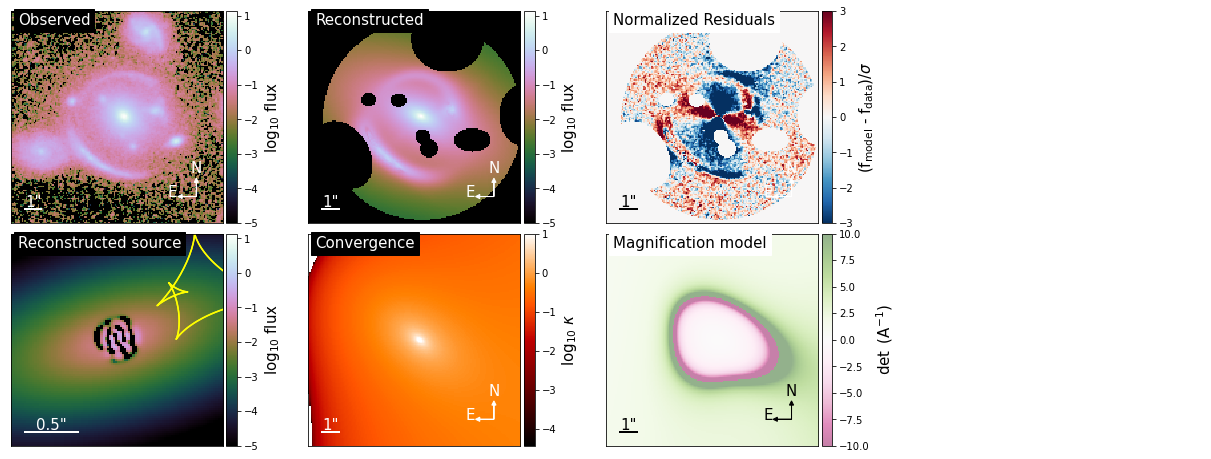

/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


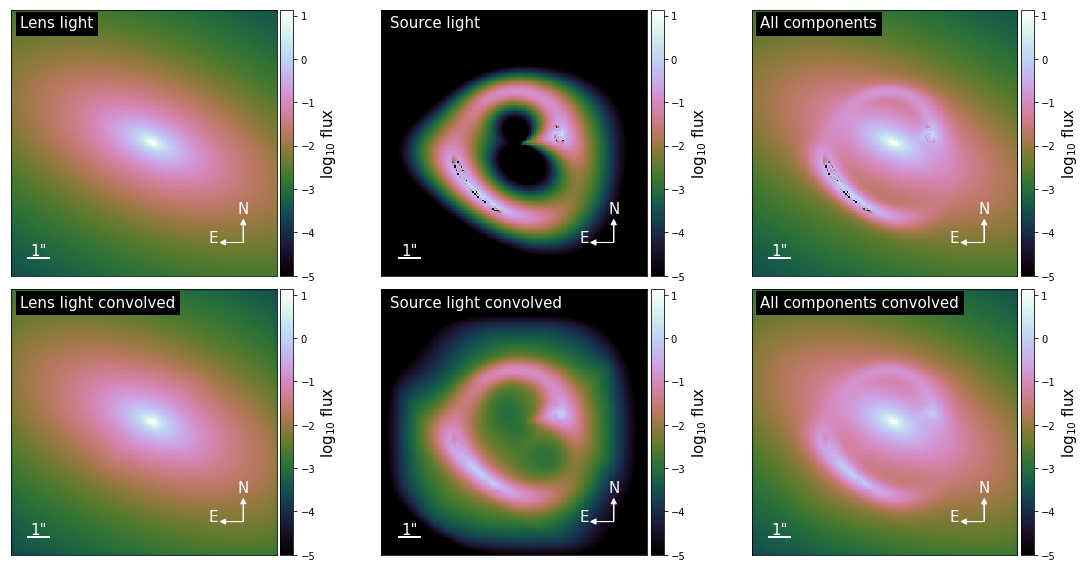

{'kwargs_lens': [{'theta_E': 2.793425691356146, 'gamma': 2.0, 'e1': 0.06654266268517545, 'e2': 0.22644390407278564, 'center_x': -0.24000319612315366, 'center_y': -0.11027447706855467}, {'gamma1': -0.018462875705713998, 'gamma2': 0.13158668460003367, 'ra_0': 0.0, 'dec_0': 0.0}, {'g1': -0.021607352967654835, 'g2': 0.011807792103270931, 'g3': -0.0377785906372968, 'g4': -0.031240127796131584, 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 41.85749429109039, 'R_sersic': 0.28644962065169116, 'n_sersic': 1.0, 'e1': 0.3435343444490542, 'e2': -0.1919116543544301, 'center_x': 0.5430729803587052, 'center_y': -0.49463976257404424}, {'amp': array([-179.82212965,  -83.44122994,  -67.3970604 ,  152.52583576,
       -238.17168128,   96.94205569, -161.24992494,  -30.89311312,
          2.11333055,  -47.25884722, -269.12744007,  381.20108001,
       -157.72280049,   12.87670625, -202.31595485,  -75.18666977,
        163.29359073, -352.24433812,  155.51785882,  172.97400848,
         92.9447967 ,

In [15]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, with_caustics=True, scale_size=0.5, numPix=100
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

In [16]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "DESIJ12054110_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

In [17]:
# joblib.load('DESIJ1205+4110_pso_output.joblib')

In [18]:
# Define the path to the backend file
mcmc_backend = "mcmc_backend.h5"

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": 0,
            "n_run": 2,
            "n_walkers": 200,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,
        },
    ]
]


chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq.best_fit()

100%|████████████████████████████████████████████| 2/2 [04:07<00:00, 123.72s/it]


Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  0
Sampling iterations (in current run): 2
253.36540055274963 time taken for MCMC sampling


## Trace Plots

In [314]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'g1_lens2', 'g2_lens2', 'g3_lens2', 'g4_lens2', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Shape of samples: (921600, 24)



/tmp/ipykernel_9719/1616189246.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 4608, N_walkers: 200, N_params: 24
theta_E_lens0 2.8148 ± 0.0068
gamma_lens0 2.0463 ± 0.0239
e1_lens0 0.1305 ± 0.0053
e2_lens0 0.1841 ± 0.0060
center_x_lens0 -0.1134 ± 0.0135
center_y_lens0 -0.1216 ± 0.0137
gamma1_lens1 0.0180 ± 0.0032
gamma2_lens1 0.0945 ± 0.0045
g1_lens2 -0.0787 ± 0.0047
g2_lens2 0.0187 ± 0.0020
g3_lens2 -0.0671 ± 0.0022
g4_lens2 -0.0415 ± 0.0050
R_sersic_source_light0 0.2179 ± 0.0091
e1_source_light0 0.3417 ± 0.0227
e2_source_light0 -0.3959 ± 0.0233
center_x_source_light0 0.6896 ± 0.0274
center_y_source_light0 -0.5493 ± 0.0312
beta_source_light1 0.1997 ± 0.0004
R_sersic_lens_light0 2.1780 ± 0.0346
e1_lens_light0 0.0242 ± 0.0018
e2_lens_light0 0.1126 ± 0.0016
center_x_lens_light0 -0.3262 ± 0.0005
center_y_lens_light0 -0.0642 ± 0.0006
R_sersic_lens_light1 0.7524 ± 0.0109


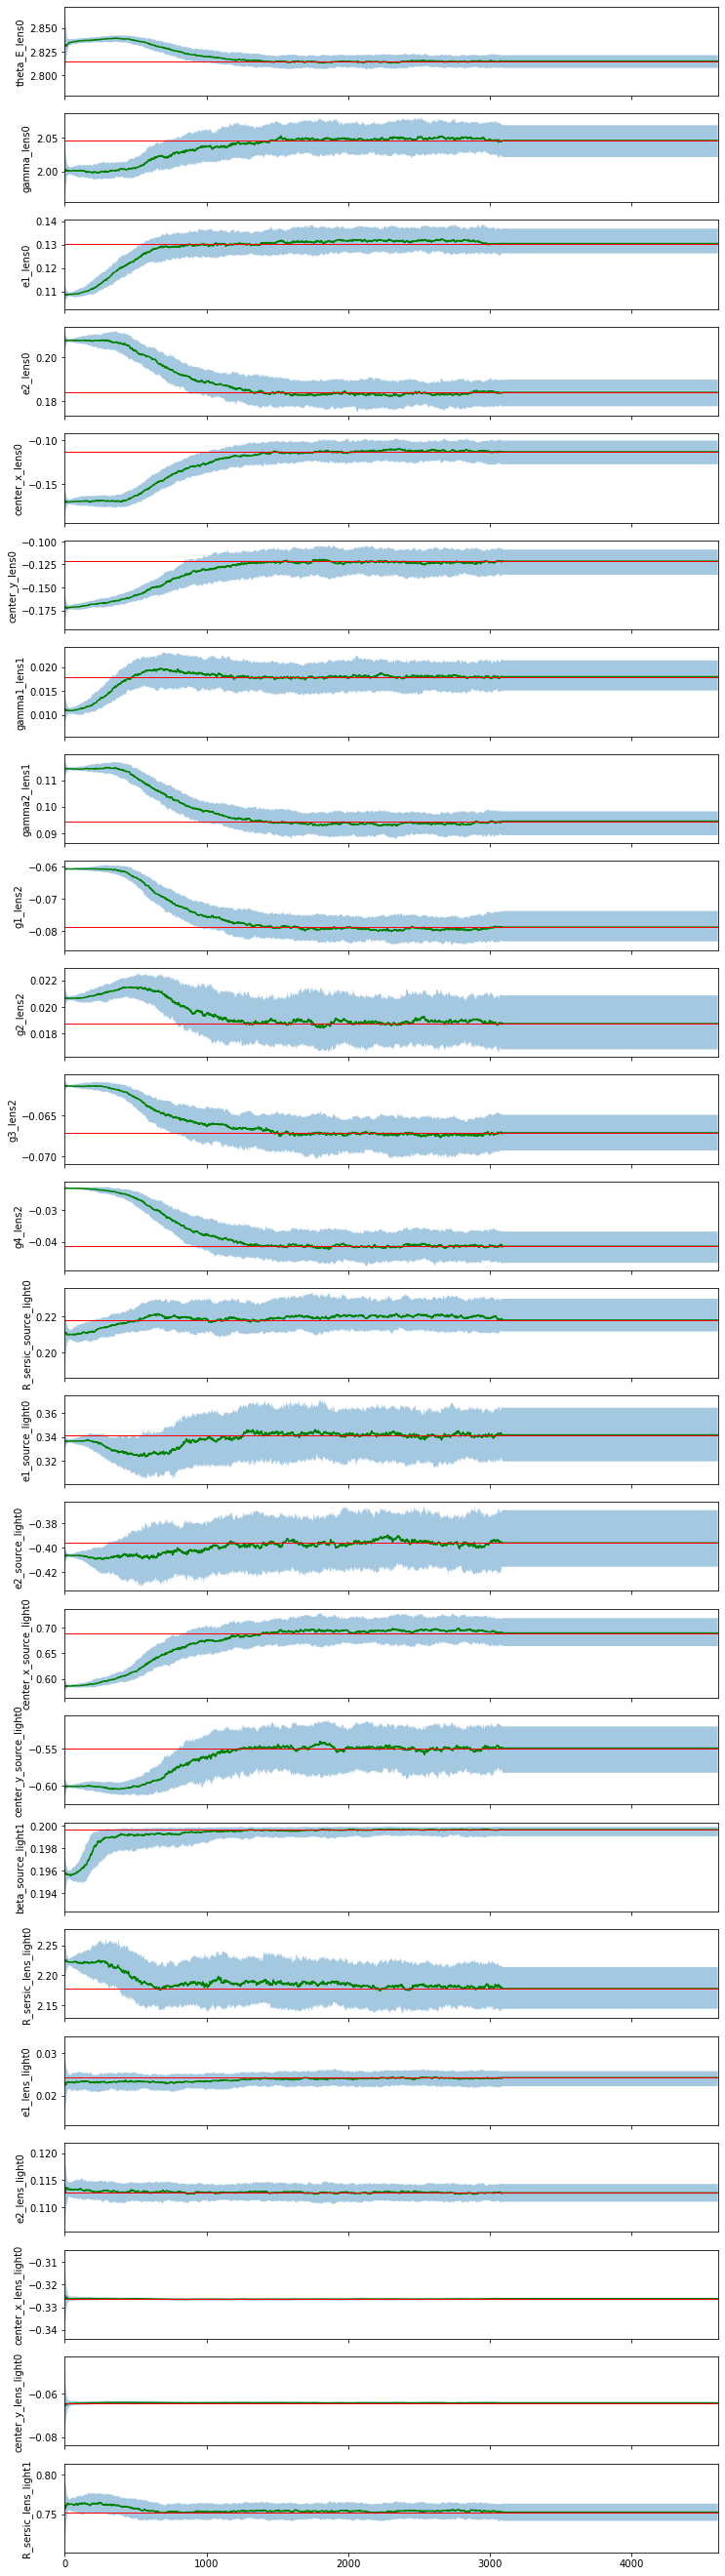

In [315]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 200
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

## Corner Plot

Number of non-linear parameters in the MCMC process: 24
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'g1_lens2', 'g2_lens2', 'g3_lens2', 'g4_lens2', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Number of evaluations in the MCMC process: 921600
921600
Shape of samples_mcmc_cut: (11200, 24)


/tmp/ipykernel_9719/4053293523.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


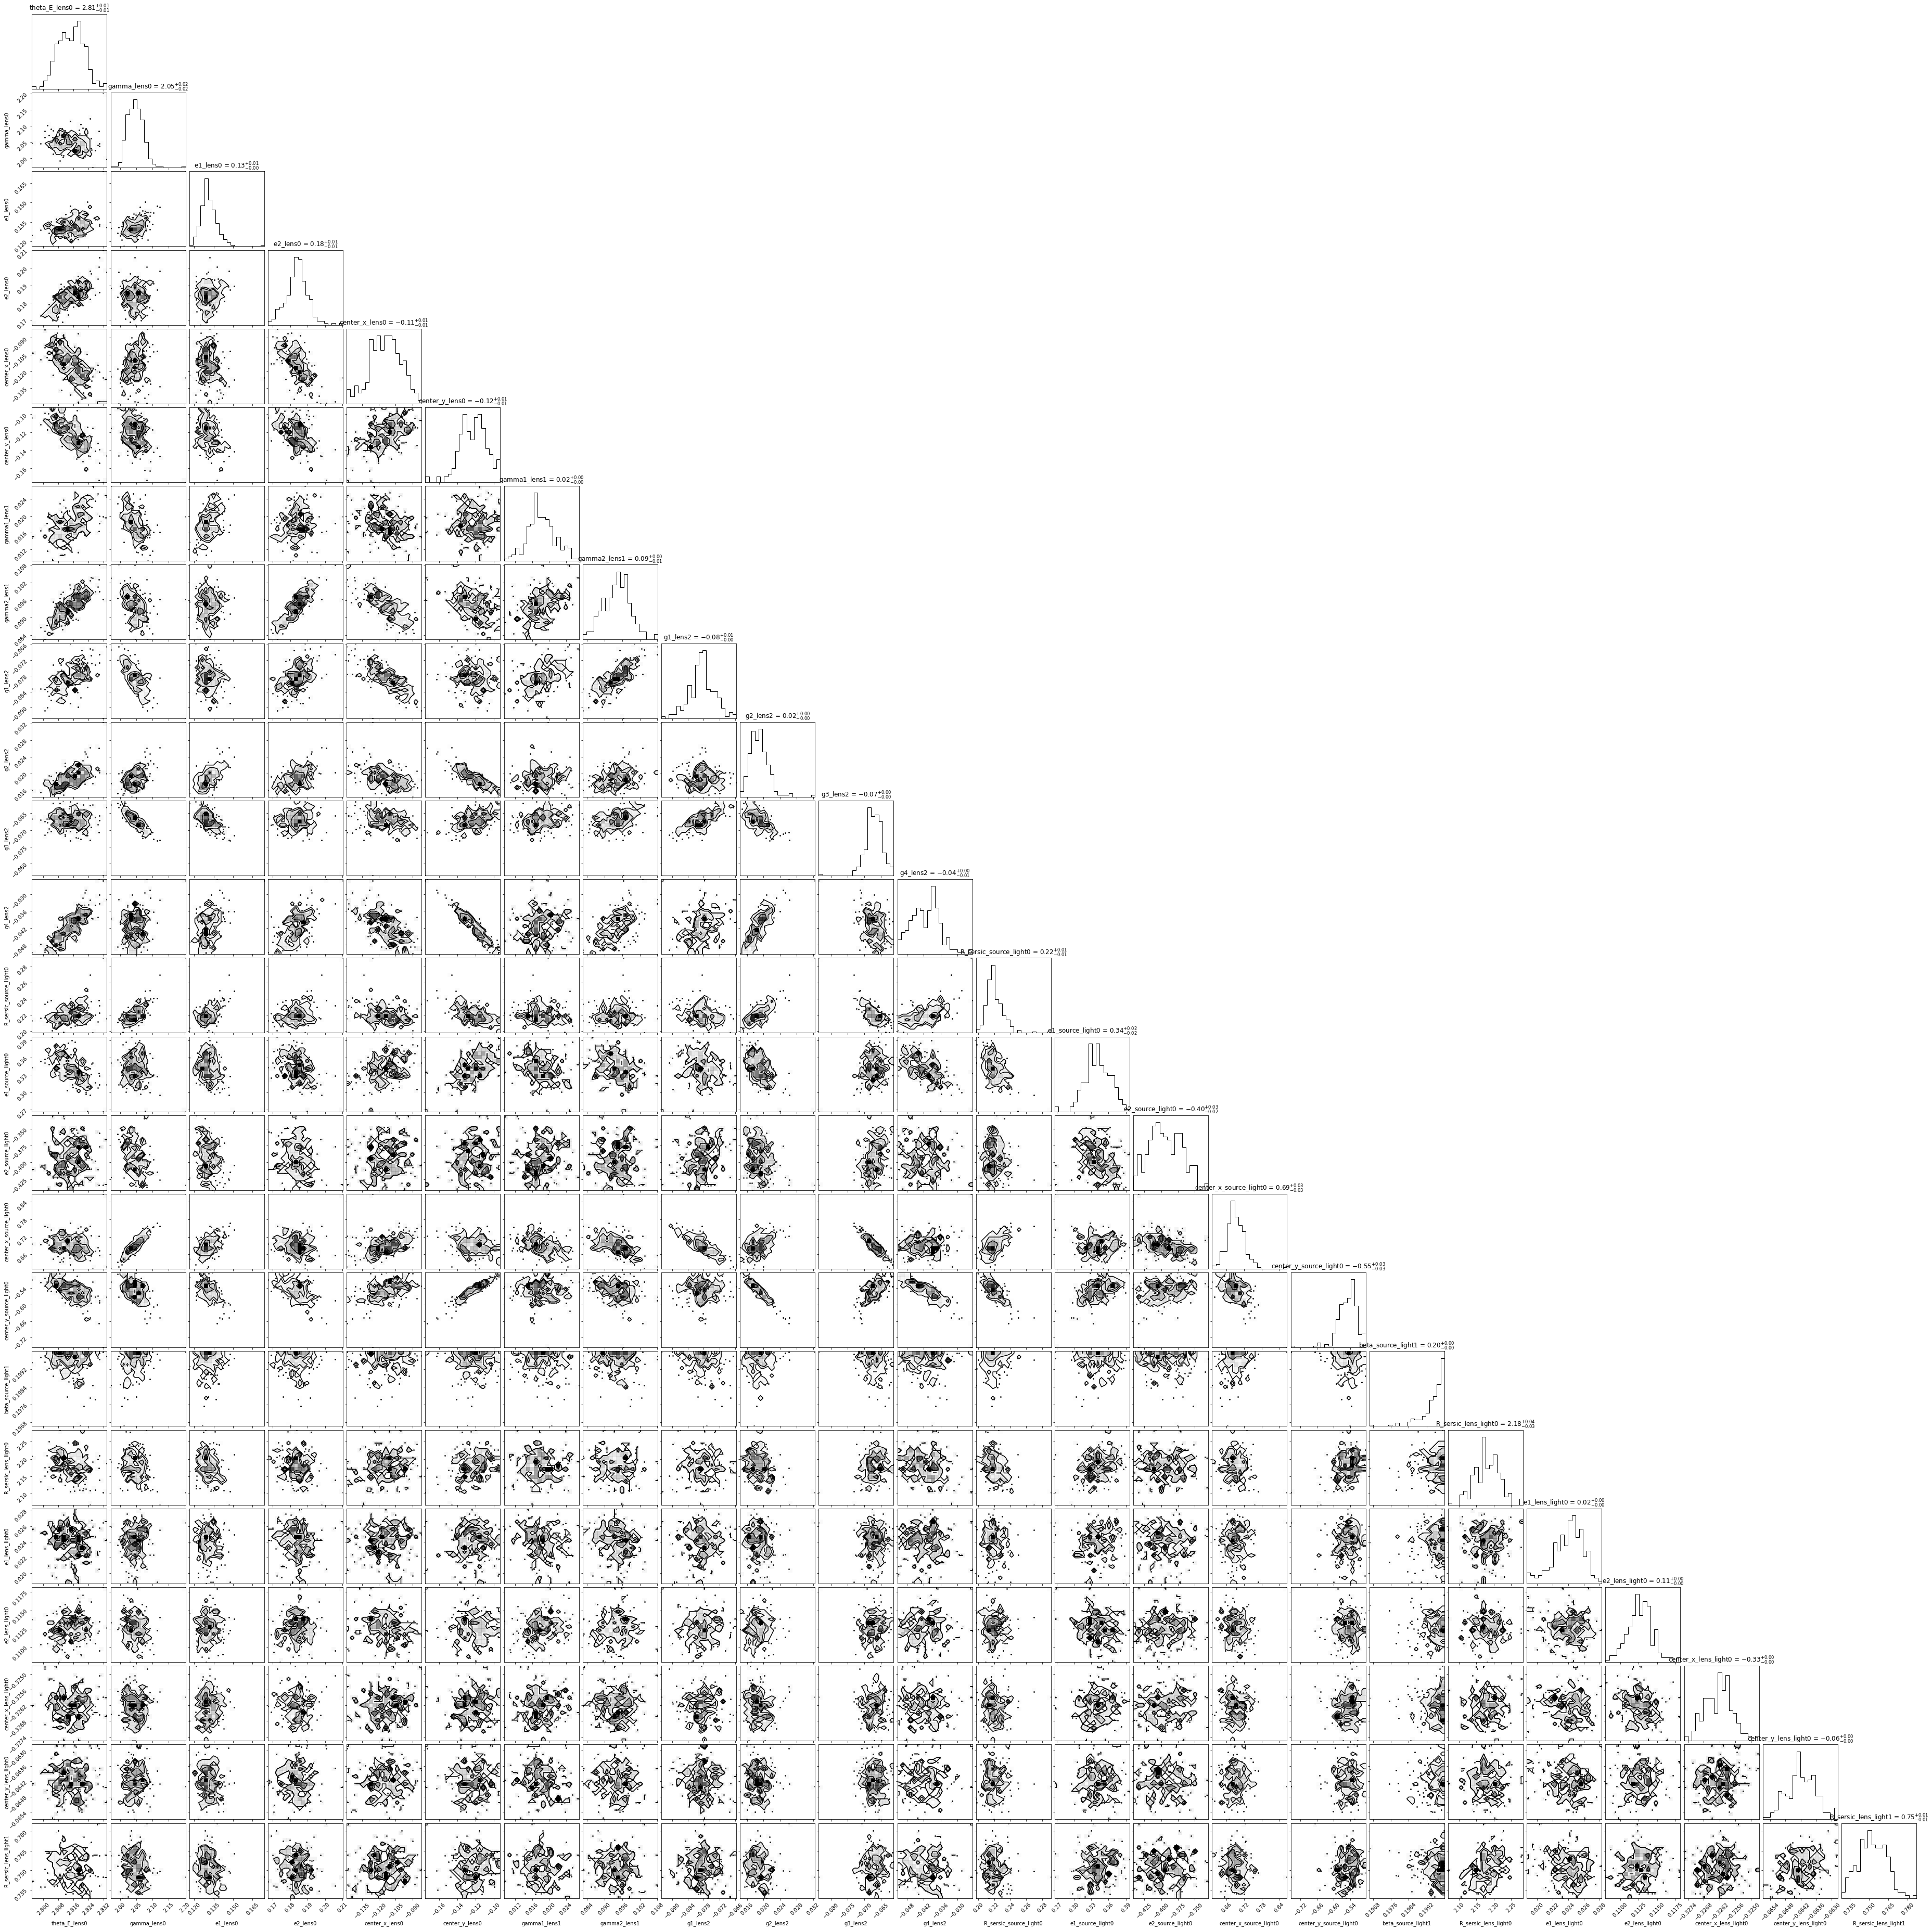

In [316]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 3500
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

## MCMC: Visualizing the Fitted Model

-1.0641606617613553 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0641606617613486


/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: invalid value encountered in log10
  np.log10(self._model),
/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:286: RuntimeWarning: invalid value encountered in log10
  np.log10(kappa_res

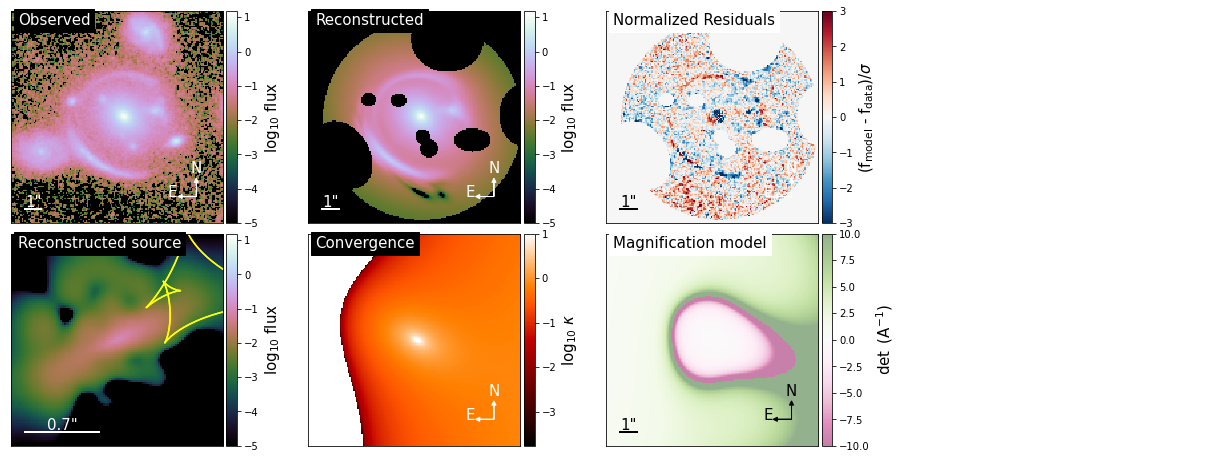

/home/robin/.local/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


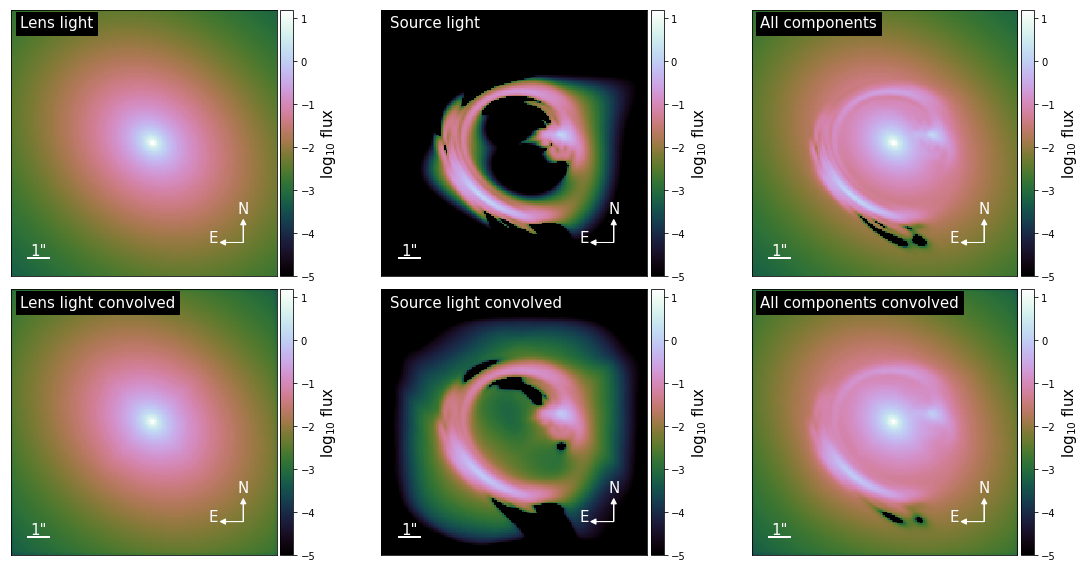

{'kwargs_lens': [{'theta_E': 2.815029963227186, 'gamma': 2.031424934572511, 'e1': 0.12782569000079827, 'e2': 0.18543453575991228, 'center_x': -0.11133708717739262, 'center_y': -0.11706668689631242}, {'gamma1': 0.018030539555910618, 'gamma2': 0.095708597126708, 'ra_0': 0.0, 'dec_0': 0.0}, {'g1': -0.07709879405146491, 'g2': 0.01755196856466048, 'g3': -0.06569049125503566, 'g4': -0.042354827318436074, 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 46.67002698712844, 'R_sersic': 0.21149807993585085, 'n_sersic': 1.0, 'e1': 0.3578384484262776, 'e2': -0.39490797439301356, 'center_x': 0.6763842803152322, 'center_y': -0.5340787510805667}, {'amp': array([ 1.47781035e+01, -5.22714466e+00,  2.67110936e+01,  1.46357834e+01,
       -3.46099131e+00,  9.53561954e+00,  1.09581653e+01,  1.15753600e+00,
        9.12977678e+00, -8.83404867e+00,  1.24335179e+01, -1.56911944e+01,
        9.71624277e+00, -3.78104893e+00,  3.03476407e+00,  5.65949689e+00,
       -4.97956178e+00,  4.56655376e+00, -5.77

In [317]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.02, numPix=100, with_caustics=True, scale_size=0.7
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

# Comparision between Mass and Light's Ellipticity of the Lens Galaxy

In [318]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}".format(
        mass_q,
        light_q,
    )
)

mass_q: 0.6323559816952543,
light_q: 0.7918885279421154


## Save the Best Fit Parameters (MCMC)

In [319]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

# Defining shortened_samples_mcmc
if samples_mcmc is not None:
    print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    burnin = 4500
    thin = 20
    shortened_samples_mcmc = chain[:, burnin::thin, :].reshape((-1, n_params))
print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)


output = [
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
]
output_path = "DESIJ1205+4110_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=9)

Number of evaluations in the MCMC process: 921600
921600
Shape of shortened_samples_mcmc: (1200, 24)


In [320]:
# joblib.load("DESIJ1205+4110_mcmc_output.joblib")

## Make dictionary of environment_params from the sigma_10 notebook

In [321]:
%store -r R_10_1
%store -r R_20_1
%store -r Sigma_10_1
%store -r Sigma_20_1

%store -r R_10_all
%store -r R_20_all
%store -r Sigma_10_all
%store -r Sigma_20_all

environment_params = {
    """    "R 10": R_10_1,
    "R_20": R_20_1,
    "Sigma 10": Sigma_10_1,
    "Sigma 20": Sigma_20_1,
    "R 10 all": R_10_all,
    "R 20 all": R_20_all,
    "Sigma 10_all": Sigma_10_all,
    "Sigma 20_all": Sigma_20_all,"""
}

print(environment_params)

{'R 10': 17.16058295852872, 'R_20': 18.219790081596404, 'Sigma 10': 0.01661682641097608, 'Sigma 20': 0.01917756153953395, 'R 10 all': 11.599975110551629, 'R 20 all': 14.47891029466427, 'Sigma 10_all': 0.023655711366407022, 'Sigma 20_all': 0.030367453010269836}


# YAML file

In [330]:
# The list of parameters to be included in the yaml file without conversion
list_params = [
    "theta_E_lens0",
    "gamma_lens0",
    "center_x_lens0",
    "center_y_lens0",
    "center_x_lens_light0",
    "center_y_lens_light0",
]

# Uncertainty calculation
median_sample = np.zeros(n_params)
q16_sample = np.zeros(n_params)
q84_sample = np.zeros(n_params)
values = {}

for i in range(n_params):
    median_sample[i] = np.median(shortened_samples_mcmc[:, i])
    q16_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 16.0)
    q84_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 84.0)

    values[param_mcmc[i]] = [
        median_sample[i],
        q84_sample[i] - median_sample[i],
        median_sample[i] - q16_sample[i],
    ]
# parameters filtered by list params
parameter_values = {k: values.get(k) for k in list_params}
print("\n", parameter_values)  # ['theta_E_lens0'][0])


 {'theta_E_lens0': [2.8148239505938975, 0.006331239389367749, 0.0072523278600922225], 'gamma_lens0': [2.0462630330040947, 0.023009299284685536, 0.02485536255393006], 'center_x_lens0': [-0.11338313443636241, 0.012786593817940992, 0.014291922980392613], 'center_y_lens0': [-0.12155809568790044, 0.01270291182274104, 0.014623303232604024], 'center_x_lens_light0': [-0.3261913225419445, 0.0004201335055761257, 0.0005956539953901885], 'center_y_lens_light0': [-0.06422090332954569, 0.0005713663309635519, 0.0005821114766730306]}


### Conversion

In [331]:
list_params_prior = [
    "e1_lens0",
    "e2_lens0",
    "gamma1_lens1",
    "gamma2_lens1",
    "e1_lens_light0",
    "e2_lens_light0",
]

list_params_posterior = [
    "phi_mass",
    "q_mass",
    "gamma_shear",
    "phi_shear",
    "phi_light",
    "q_light",
]
n_params_prior = len(list_params_prior)
n_params_posterior = len(list_params_posterior)
length_shortened = len(shortened_samples_mcmc)

prior_samples = np.zeros((length_shortened, n_params_prior))

# Copying the selected (prior) parameters from shortened samples
for j in list_params_prior:
    if j in param_mcmc:
        prior_samples[:, list_params_prior.index(j)] = shortened_samples_mcmc[
            :, param_mcmc.index(j)
        ]
    else:
        print(f"Warning: Parameter '{j}' not found in param_mcmc.")


# Initializing an array for saving the converted parameter values
posterior_samples = np.zeros((length_shortened, n_params_posterior))

for i in range(0, n_params_posterior, 2):
    if i == 0 or i == 4:
        for j in range(length_shortened):
            (
                posterior_samples[j][i],
                posterior_samples[j][i + 1],
            ) = param_util.ellipticity2phi_q(
                prior_samples[j][i], prior_samples[j][i + 1]
            )
    elif i == 2:
        for k in range(length_shortened):
            (
                posterior_samples[k][i],
                posterior_samples[k][i + 1],
            ) = param_util.shear_cartesian2polar(
                prior_samples[k][i], prior_samples[k][i + 1]
            )
            # print(posterior_samples[k][i], posterior_samples[k][i+1])
    else:
        print("Array Index Out of Range")

# Uncertainty calculation
median_sample_posterior = np.zeros(n_params_posterior)
q84_sample_posterior = np.zeros(n_params_posterior)
q16_sample_posterior = np.zeros(n_params_posterior)

values_posterior = {}


for i in range(n_params_posterior):
    median_sample_posterior[i] = np.median(posterior_samples[:, i])
    q16_sample_posterior[i] = np.percentile(posterior_samples[:, i], 16.0)
    q84_sample_posterior[i] = np.percentile(posterior_samples[:, i], 84.0)

    values_posterior[list_params_posterior[i]] = [
        median_sample_posterior[i],
        q84_sample_posterior[i] - median_sample_posterior[i],
        median_sample_posterior[i] - q16_sample_posterior[i],
    ]
# print(values_posterior)
# marge previous parameters and new converted parameters
parameter_values.update(values_posterior)
print(parameter_values)

{'theta_E_lens0': [2.8148239505938975, 0.006331239389367749, 0.0072523278600922225], 'gamma_lens0': [2.0462630330040947, 0.023009299284685536, 0.02485536255393006], 'center_x_lens0': [-0.11338313443636241, 0.012786593817940992, 0.014291922980392613], 'center_y_lens0': [-0.12155809568790044, 0.01270291182274104, 0.014623303232604024], 'center_x_lens_light0': [-0.3261913225419445, 0.0004201335055761257, 0.0005956539953901885], 'center_y_lens_light0': [-0.06422090332954569, 0.0005713663309635519, 0.0005821114766730306], 'phi_mass': [0.4752486793617888, 0.012082340737309627, 0.012238669723790674], 'q_mass': [0.6314176629930193, 0.008144915242756401, 0.007085066636557058], 'gamma_shear': [0.6913103936572694, 0.011897385056966248, 0.017224600948387292], 'phi_shear': [0.09633630231525811, 0.004160906219581914, 0.005456028658400239], 'phi_light': [0.6797307399220421, 0.008069410035359548, 0.007091307666545976], 'q_light': [0.7933019814769129, 0.002785708595323011, 0.002246841212273365]}


### Half-light radius calculation

In [332]:
light_model = LightModel(lens_light_model_list)
analysis = LightProfileAnalysis(light_model)

# Providing the lens light results from MCMC
kwargs_light = kwargs_result_mcmc["kwargs_lens_light"]

# Calculate the half-light radius
half_light_radius = analysis.half_light_radius(
    kwargs_light, grid_spacing=0.01, grid_num=10 / 0.01
)
print("Half-light radius:", half_light_radius)

# Adding to the dictionary
parameter_values["R_eff_light"] = half_light_radius
print(parameter_values)

Half-light radius: 0.890063589750755
{'theta_E_lens0': [2.8148239505938975, 0.006331239389367749, 0.0072523278600922225], 'gamma_lens0': [2.0462630330040947, 0.023009299284685536, 0.02485536255393006], 'center_x_lens0': [-0.11338313443636241, 0.012786593817940992, 0.014291922980392613], 'center_y_lens0': [-0.12155809568790044, 0.01270291182274104, 0.014623303232604024], 'center_x_lens_light0': [-0.3261913225419445, 0.0004201335055761257, 0.0005956539953901885], 'center_y_lens_light0': [-0.06422090332954569, 0.0005713663309635519, 0.0005821114766730306], 'phi_mass': [0.4752486793617888, 0.012082340737309627, 0.012238669723790674], 'q_mass': [0.6314176629930193, 0.008144915242756401, 0.007085066636557058], 'gamma_shear': [0.6913103936572694, 0.011897385056966248, 0.017224600948387292], 'phi_shear': [0.09633630231525811, 0.004160906219581914, 0.005456028658400239], 'phi_light': [0.6797307399220421, 0.008069410035359548, 0.007091307666545976], 'q_light': [0.7933019814769129, 0.002785708595

### Creating the YAML file

In [333]:
# marge parameter_values and environment_values
parameter_values.update(environment_params)
print(parameter_values)
# make all the numpy variales to float
parameter_values = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in parameter_values.items()
}

# Write the dictionary to a YAML file
yaml_file_name = "DESIJ1205+4110_point_estimates.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(parameter_values, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

{'theta_E_lens0': [2.8148239505938975, 0.006331239389367749, 0.0072523278600922225], 'gamma_lens0': [2.0462630330040947, 0.023009299284685536, 0.02485536255393006], 'center_x_lens0': [-0.11338313443636241, 0.012786593817940992, 0.014291922980392613], 'center_y_lens0': [-0.12155809568790044, 0.01270291182274104, 0.014623303232604024], 'center_x_lens_light0': [-0.3261913225419445, 0.0004201335055761257, 0.0005956539953901885], 'center_y_lens_light0': [-0.06422090332954569, 0.0005713663309635519, 0.0005821114766730306], 'phi_mass': [0.4752486793617888, 0.012082340737309627, 0.012238669723790674], 'q_mass': [0.6314176629930193, 0.008144915242756401, 0.007085066636557058], 'gamma_shear': [0.6913103936572694, 0.011897385056966248, 0.017224600948387292], 'phi_shear': [0.09633630231525811, 0.004160906219581914, 0.005456028658400239], 'phi_light': [0.6797307399220421, 0.008069410035359548, 0.007091307666545976], 'q_light': [0.7933019814769129, 0.002785708595323011, 0.002246841212273365], 'R_eff

### Read the YAML file using safe_load

In [334]:
with open(yaml_file_name, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 21
{'R 10': 17.16058295852872, 'R 10 all': 11.599975110551629, 'R 20 all': 14.47891029466427, 'R_20': 18.219790081596404, 'R_eff_light': 0.890063589750755, 'Sigma 10': 0.01661682641097608, 'Sigma 10_all': 0.023655711366407022, 'Sigma 20': 0.01917756153953395, 'Sigma 20_all': 0.030367453010269836, 'center_x_lens0': [-0.11338313443636241, 0.012786593817940992, 0.014291922980392613], 'center_x_lens_light0': [-0.3261913225419445, 0.0004201335055761257, 0.0005956539953901885], 'center_y_lens0': [-0.12155809568790044, 0.01270291182274104, 0.014623303232604024], 'center_y_lens_light0': [-0.06422090332954569, 0.0005713663309635519, 0.0005821114766730306], 'gamma_lens0': [2.0462630330040947, 0.023009299284685536, 0.02485536255393006], 'gamma_shear': [0.6913103936572694, 0.011897385056966248, 0.017224600948387292], 'phi_light': [0.6797307399220421, 0.008069410035359548, 0.007091307666545976], 'phi_mass': [0.4752486793617888, 0.012082340737309627, 0.012238669723790674